## Importando dados de fragmentação (MS/MS)

A biblioteca _matchms_ pode importar dados de MS/MS em vários formatos, como .mzml, .mzxml ou arquivos .mgf no estilo GNPS. Outra opção seria usar o Identificador Universal de Espectro para espectros de massa [_Universal Spectrum Identifier for mass spectra_](https://www.biorxiv.org/content/10.1101/2020.12.07.415539v1.full).
Vamos começar com alguns espectros do GNPS em formato de arquivo .mgf que podem ser obtidos [aqui](https://external.gnps2.org/gnpslibrary). Para o exemplo a seguir, baixamos esta biblioteca de espectros.

In [ ]:
!pip install matchms matchmsextras

Calcular similaridades de espectros: _Score_ de cosseno modificado [Watrous et al. (PNAS, 2012)](https://www.pnas.org/content/109/26/E1743).

In [1]:
from matchms.importing import load_from_mgf

spectra = list(load_from_mgf("specs_ms.mgf"))

In [2]:
len(spectra)

398

In [3]:
spectra[0].metadata

{'pepmass': (568.2995, None),
 'charge': 1,
 'feature_id': '1',
 'scans': '1',
 'retention_time': 2035.505,
 'ms_level': '2',
 'precursor_mz': 568.2995}

In [4]:
#%%timeit
from matchms.similarity import ModifiedCosine
from matchms import calculate_scores

similarity_measure = ModifiedCosine(tolerance=0.005)
scores = calculate_scores(spectra, spectra, similarity_measure,
                          is_symmetric=True)

In [5]:
import networkx as nx
import matchmsextras.networking as net
from matchms.networking import SimilarityNetwork

ms_network = SimilarityNetwork(identifier_key="feature_id",
                               score_cutoff=0.7,
                               max_links=10)
ms_network.create_network(scores, score_name = "ModifiedCosine_score")
our_network = ms_network.graph

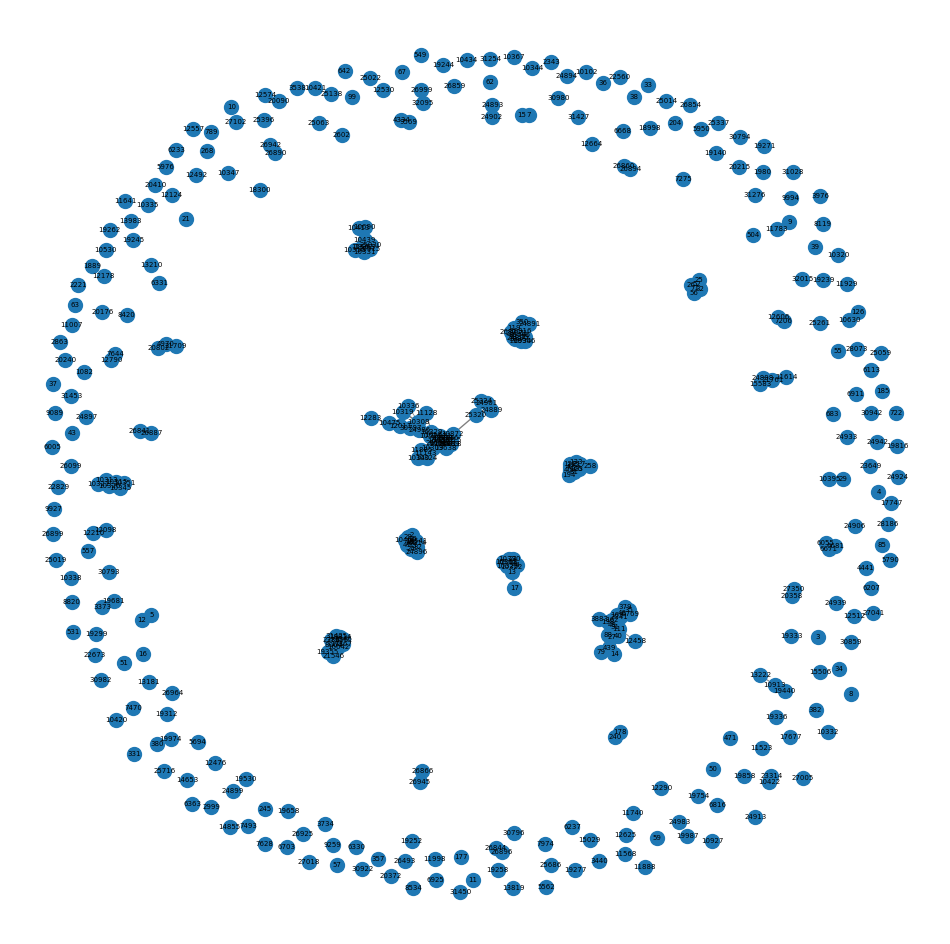

In [6]:
net.plot_cluster(our_network)

In [7]:
subnetworks = [our_network.subgraph(c).copy() for c in nx.connected_components(our_network)]

In [8]:
target_node = '10308'

clusters = {}
for i, subnet in enumerate(subnetworks):
    if len(subnet.nodes) > 2: # exclude clusters with <=2 nodes
        if target_node in subnet.nodes:
            print(target_node, 'is in component:', i)
        clusters[i] = len(subnet.nodes)
        
clusters

10308 is in component: 3


{0: 14,
 2: 13,
 3: 36,
 6: 11,
 7: 19,
 12: 11,
 17: 6,
 21: 9,
 42: 4,
 45: 11,
 46: 3,
 67: 6,
 94: 3,
 162: 3}

In [13]:
len(subnetworks[3].nodes())

36

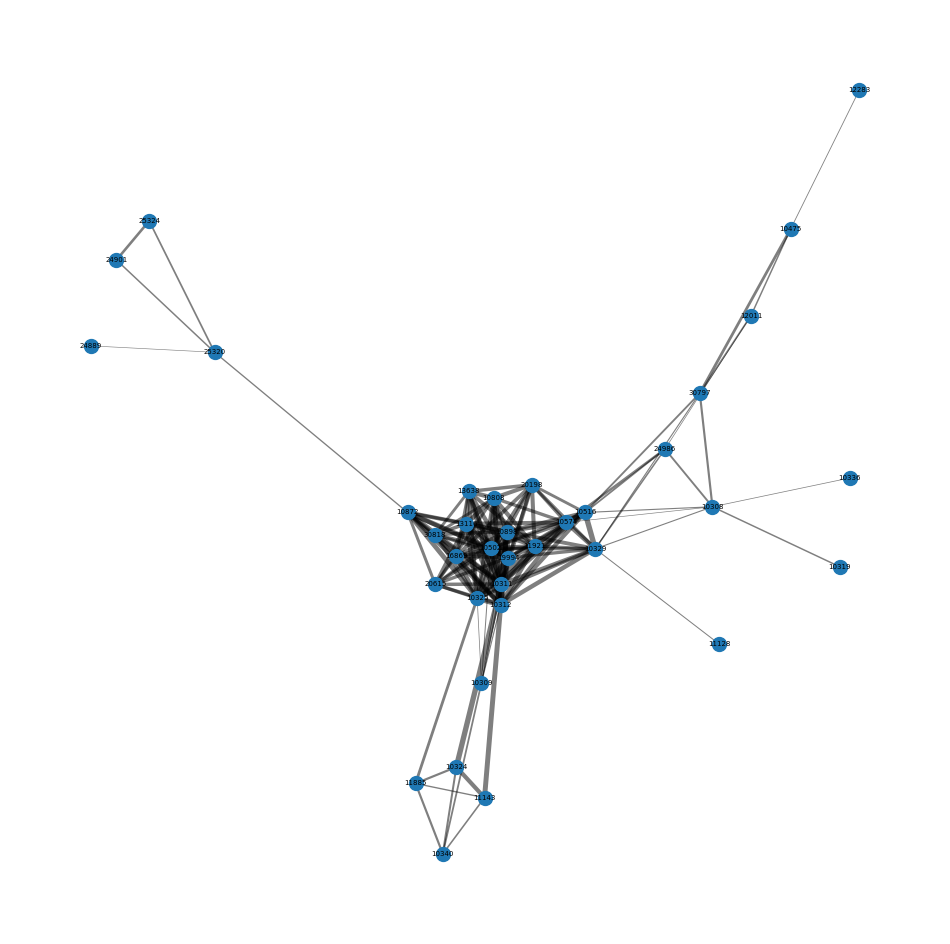

In [14]:
net.plot_cluster(subnetworks[3])

In [15]:
nx.write_graphml(our_network, "results/network_GNPS_cutoff_07.graphml")